In [1]:
tar_path = 'data/'
ball_video_path = 'Vid_A_ball'
cup_video_path = 'Vid_B_cup'
person_video_path = 'Vid_D_person'
extract_to = 'data'

In [2]:
import tarfile

with tarfile.open(tar_path+ball_video_path+'.tar.xz') as f:
    f.extractall(extract_to)
    
with tarfile.open(tar_path+cup_video_path+'.tar.xz') as f:
    f.extractall(extract_to)
    
with tarfile.open(tar_path+person_video_path+'.tar.xz') as f:
    f.extractall(extract_to)

In [3]:
%matplotlib notebook
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import time
import numpy as np
from train import *
from networks import *
from ResED import *
from functions import *
from imageloader import *
from torch import optim

# Load Cropped Frames

In [4]:
ball_frames_cropped, ball_height_cropped, ball_width_cropped = get_cropped_frames(tar_path + ball_video_path)
cup_frames_cropped, cup_height_cropped, cup_width_cropped = get_cropped_frames(tar_path + cup_video_path)
person_frames_cropped, person_height_cropped, person_width_cropped = get_cropped_frames(tar_path + person_video_path)

# Load Training Image

## 1. Ball

In [5]:
ball_img_name = 'img0002.jpg'
ball_img_path = tar_path + ball_video_path + '/' + ball_img_name
ball_start_point = (200, 115)   
ball_end_point = (245, 160)
ball_center_coordinates = (224, 136)
ball_radius = 23
ball_padding = 35

In [6]:
ball_img, ball_flatten_labels, ball_foreground, ball_background, ball_marked_img = load_image_circle_flatten_labels(ball_img_path, ball_start_point, ball_end_point,
                                 ball_padding, ball_center_coordinates, ball_radius)

<IPython.core.display.Javascript object>


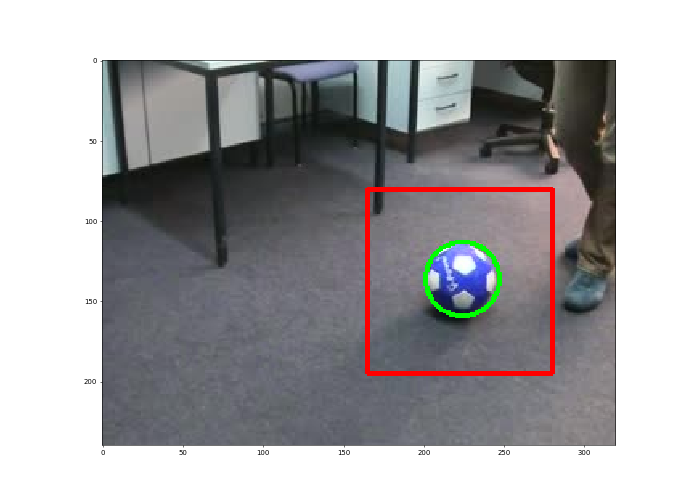

In [226]:
fig = plt.figure(figsize=(14, 10), dpi= 50, facecolor='w', edgecolor='k')
plt.imshow(ball_marked_img)
plt.show()

In [8]:
plt.close()

<IPython.core.display.Javascript object>


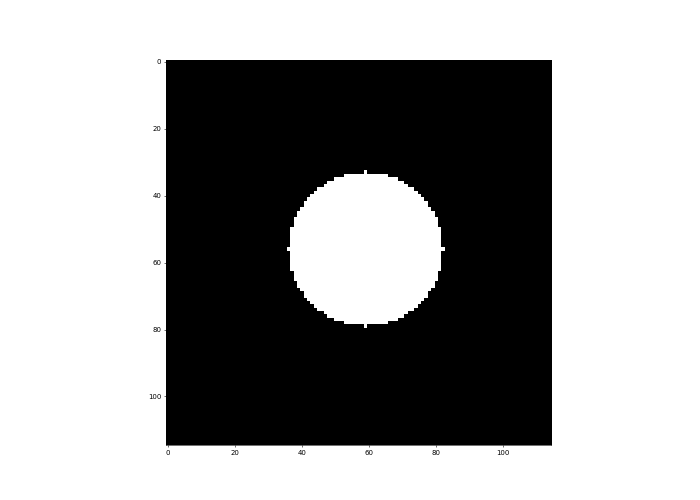

In [227]:
test_flatten_labels = ball_flatten_labels.reshape((ball_img.shape[-2], ball_img.shape[-1]))
fig = plt.figure(figsize=(14, 10), dpi= 50, facecolor='w', edgecolor='k')
plt.imshow(test_flatten_labels, cmap=plt.cm.gray)
plt.show()

In [11]:
plt.close()

## 2. Cup

In [7]:
cup_img_name = 'img0002.jpg'
cup_img_path = tar_path + cup_video_path + '/' + cup_img_name
cup_start_point = (122, 92)   
cup_end_point = (170, 148)
cup_start_point2 = (170,103)   
cup_end_point2 = (188, 140)
cup_padding = 35

In [8]:
cup_img, cup_flatten_labels, cup_foreground, cup_background, cup_marked_img = load_image_cup_flatten_labels(cup_img_path, cup_start_point,
                                                                                                            cup_end_point, cup_start_point2, cup_end_point2,  cup_padding)

<IPython.core.display.Javascript object>


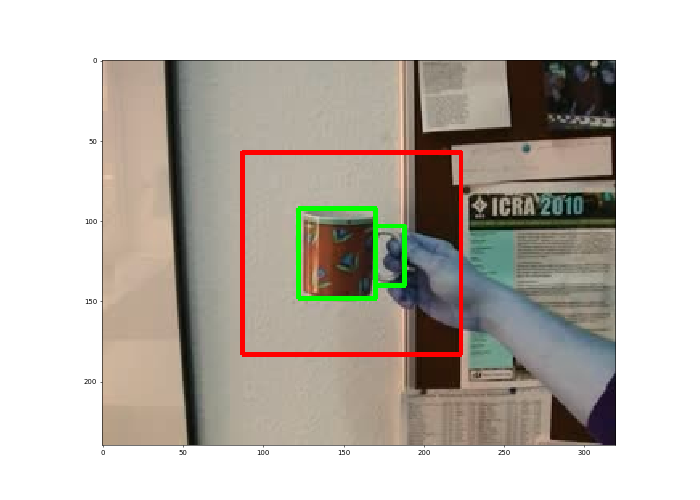

In [230]:
fig = plt.figure(figsize=(14, 10), dpi= 50, facecolor='w', edgecolor='k')
plt.imshow(cup_marked_img)
plt.show()

In [15]:
plt.close()

<IPython.core.display.Javascript object>


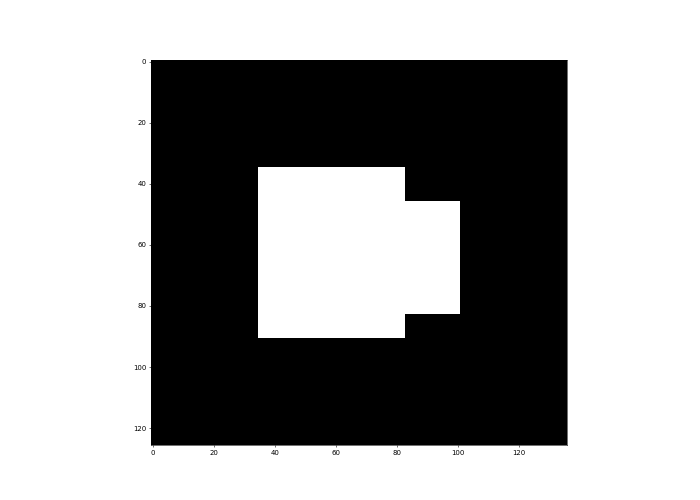

In [231]:
test_flatten_labels = cup_flatten_labels.reshape((cup_img.shape[-2], cup_img.shape[-1]))
fig = plt.figure(figsize=(14, 10), dpi= 50, facecolor='w', edgecolor='k')
plt.imshow(test_flatten_labels, cmap=plt.cm.gray)
plt.show()

In [17]:
plt.close()

## 3. Person

In [9]:
person_img_name = 'img0002.jpg'
person_img_path = tar_path + person_video_path + '/' + person_img_name
# person_start_point = (136, 55)
# person_end_point = (179, 187)
person_rect_points = [((146, 78), (170, 84)),
                      ((138, 85), (170, 133)),
                      ((170, 84), (178, 133)),
                      ((148, 132), (157, 184)),
                      ((162, 134), (171, 187)), 
                      ((141, 182), (149, 186)),
                      ((154, 74), (162, 77))]
face_center = (157, 67)
face_radius = 9
# person_padding = 35
person_padding_rect = ((101, 20), (214, 222))

In [10]:
person_img, person_flatten_labels, person_foreground, person_background, person_marked_img = load_image_person_flatten_labels(person_img_path, person_rect_points, face_center, face_radius, person_padding_rect, thickness=1)

<IPython.core.display.Javascript object>


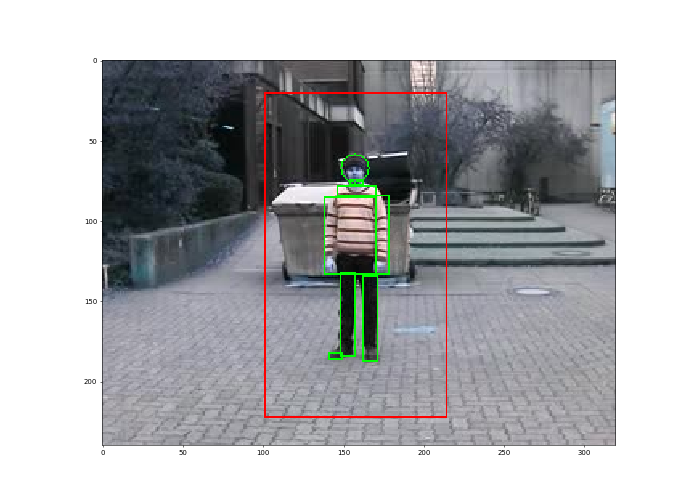

In [234]:
fig = plt.figure(figsize=(14, 10), dpi= 50, facecolor='w', edgecolor='k')
plt.imshow(person_marked_img)
plt.show()

In [21]:
plt.close()

<IPython.core.display.Javascript object>


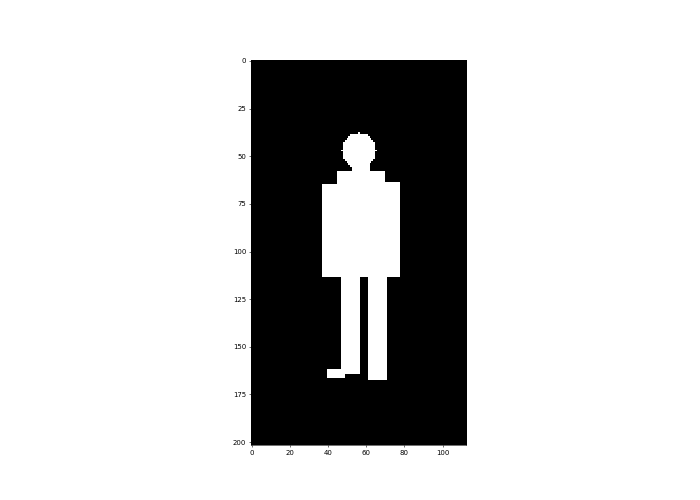

In [235]:
test_flatten_labels = person_flatten_labels.reshape((person_img.shape[-2], person_img.shape[-1]))
fig = plt.figure(figsize=(14, 10), dpi= 50, facecolor='w', edgecolor='k')
plt.imshow(test_flatten_labels, cmap=plt.cm.gray)
plt.show()

In [23]:
plt.close()

In [11]:
%matplotlib inline

## Model training

### 1.1 Ball

In [237]:
model_path = 'ball_ResED_1'
centroid_path = 'Centroids/' + model_path + '_centroids' + '.pkl'
video_path = 'Videos/'+model_path+'.avi'

In [114]:
last_out_channel = 3
model = ResED(in_channels=3,
            n_classes=last_out_channel,
            depth=3,
            wf=6,
            padding=1,
            batch_norm=True,
            up_mode='upconv')

In [115]:
print(model)

ResED(
  (down_path): ModuleList(
    (0): ResED_DownBlock(
      (block1): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (block2): Sequential(
        (0): ReLU()
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResED_DownBlock(
      (block1): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (block2): Sequential(
        (0): ReLU()
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): ResED_DownBlock(
      (block1): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (block2): Sequential(
        (0): ReLU()
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (up_path): ModuleList(
    (0): ResED_UpBlock(
      (up): ConvTrans

In [116]:
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
margin = 300
print("margin:", margin)
criterion = TripletLoss(margin)
n_epochs = 6
print(ball_img.shape)

margin: 300
torch.Size([1, 3, 115, 115])


In [117]:
model = train_model(model, criterion, ball_img, ball_flatten_labels, optimizer, ball_foreground, ball_background, num_epochs=n_epochs, batch_size=95, num_batches=95, get_min_loss=False)

Epochs:  17%|█▋        | 1/6 [01:27<07:19, 87.96s/it]

loss: 194.039444


Epochs:  33%|███▎      | 2/6 [02:55<05:51, 87.94s/it]

loss: 215.553802


Epochs:  50%|█████     | 3/6 [04:23<04:23, 87.97s/it]

loss: 119.616814


Epochs:  67%|██████▋   | 4/6 [05:52<02:56, 88.03s/it]

loss: 69.259438


Epochs:  83%|████████▎ | 5/6 [07:19<01:27, 87.71s/it]

loss: 57.922226


Epochs: 100%|██████████| 6/6 [08:46<00:00, 87.79s/it]

loss: 63.385796
Best val loss: 57.922226


In [118]:
out_features_size = 3
model.eval()

with torch.set_grad_enabled(False):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    img = ball_img.to(device)
    model = model.to(device)
    embeddings = model(img)
embeddings = embeddings.data.cpu().numpy()
print("embeddings.shape:", embeddings.shape) # Datafram will contain 9025 rows and 8 col 
print("flatten_labels.shape:", ball_flatten_labels.shape)

c, w = 0, 0
for i in embeddings:
    if np.array_equal(i, np.array([0.]*out_features_size)):
        c += 1
    else:
        w += 1
print("zeros count:", c)
print("not zeros count:", w)

embeddings.shape: (13225, 3)
flatten_labels.shape: torch.Size([13225])
zeros count: 0
not zeros count: 13225


correct: 13082, wrong: 143, accuracy: 98.91871455576559%


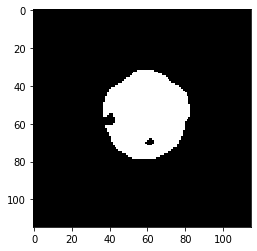

tensor([32, 32, 32,  ..., 78, 78, 78])
tensor([3854, 3963, 3964,  ..., 9034, 9035, 9144])


In [119]:
centroids = get_centroids(embeddings, ball_foreground, ball_background)
# print("centroids:", centroids)
labels_shape = img.shape[-2], img.shape[-1]
heat_map = embeddings_accuracy(embeddings, ball_flatten_labels, labels_shape, centroids, num_classes=2)
# t = .view(-1)
t = torch.tensor(heat_map)
foreground2 = torch.where(t == 1)[0]
plt.imshow(heat_map, cmap=plt.cm.gray)
plt.show()
print(foreground2)
print(ball_foreground)

In [120]:
torch.save(model.state_dict(), 'Models/'+model_path+'.pt')

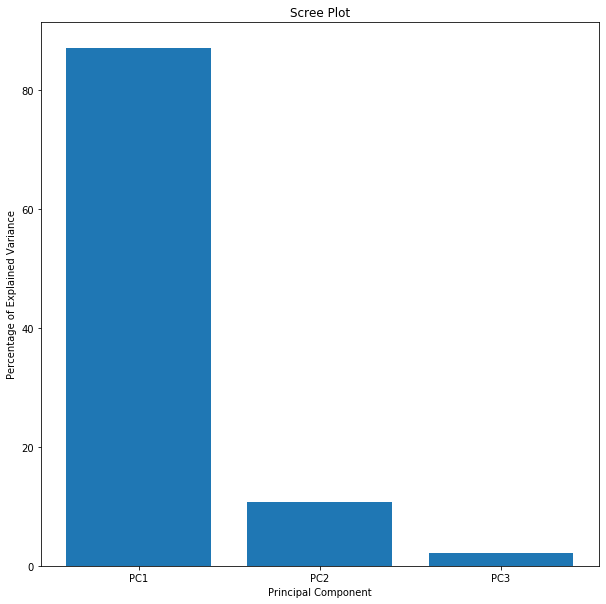

embedding3   -0.605399
embedding1    0.569464
embedding2    0.556060
dtype: float64


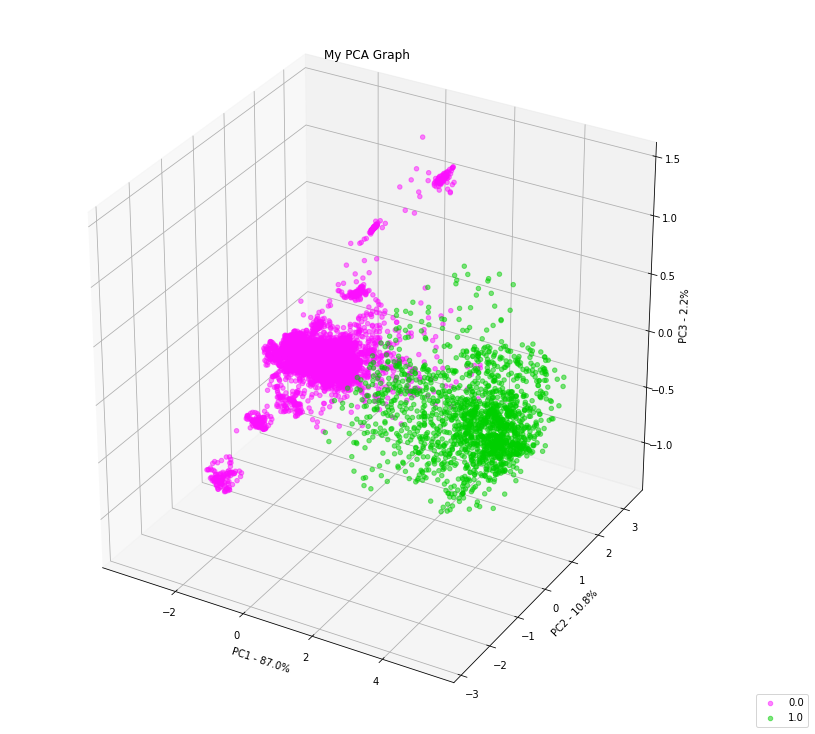

In [121]:
plot_PCA(embeddings, ball_flatten_labels, out_features_size=out_features_size,classes= [0., 1.], colors=['#fc0fff', '#00cf00'], is_3D=True, draw_PCA_per_varc=True, figure_size=(10,10), top_range_loadingfactors=(0, 3))

### save Centroids

In [122]:
model_path = 'ball_ResED_1'
centroid_path = 'Centroids/' + model_path + '_centroids' + '.pkl'
video_path = 'Videos/'+model_path+'.avi'

In [123]:
last_out_channel = 3
model = ResED(in_channels=3,
            n_classes=last_out_channel,
            depth=3,
            wf=6,
            padding=1,
            batch_norm=True,
            up_mode='upconv')

In [124]:
model.load_state_dict(torch.load('Models/'+model_path+'.pt'))

<All keys matched successfully>

In [125]:
out_features_size = last_out_channel
model.eval()

with torch.set_grad_enabled(False):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    img = ball_img.to(device)
    model = model.to(device)
    embeddings = model(img)
embeddings = embeddings.data.cpu().numpy()
print("embeddings.shape:", embeddings.shape) # Datafram will contain 9025 rows and 8 col 
print("flatten_labels.shape:", ball_flatten_labels.shape)
c, w = 0, 0
for i in embeddings:
    if np.array_equal(i, np.array([0.]*out_features_size)):
        c += 1
    else:
        w += 1
#     print(i)    
print("zeros count:", c)
print("not zeros count:", w)

embeddings.shape: (13225, 3)
flatten_labels.shape: torch.Size([13225])
zeros count: 0
not zeros count: 13225


correct: 13082, wrong: 143, accuracy: 98.91871455576559%


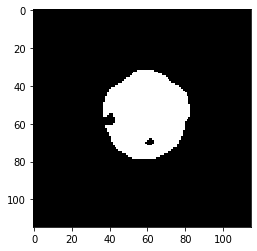

In [126]:
centroids = get_centroids(embeddings, ball_foreground, ball_background)
heat_map = embeddings_accuracy(embeddings, ball_flatten_labels, labels_shape, centroids, num_classes=2)
plt.imshow(heat_map, cmap=plt.cm.gray)
plt.show()

In [127]:
save_centroids(centroid_path, centroids)
centroids_af = load_centroids(centroid_path)
assert np.array_equal(centroids_af, centroids)

### Create Video

In [128]:
model_path = 'ball_ResED_1'
centroid_path = 'Centroids/' + model_path + '_centroids' + '.pkl'
video_path = 'Videos/'+model_path+'.avi'

last_out_channel = 3
model = ResED(in_channels=3,
            n_classes=last_out_channel,
            depth=3,
            wf=6,
            padding=1,
            batch_norm=True,
            up_mode='upconv')

centroids = load_centroids(centroid_path)
model.load_state_dict(torch.load('Models/'+model_path+'.pt'))

<All keys matched successfully>

In [129]:
frames_step = 3
real_heat_maps = easy_create_real_video(model, centroids, ball_frames_cropped, video_path,ball_width_cropped,
                                        ball_height_cropped, froucc=cv2.VideoWriter_fourcc('M','J','P','G'),
                                        use_gpu=True, fps=10, frames_step=frames_step, num_classes=2,
                                        ret_heat_maps=True, heatmap_path = 'heatmaps/heatmap', img_ext = '.jpg')

Generate Heat Maps: 100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


Time Elapsed (get_heatmaps func) 1m 17s


<Figure size 432x288 with 0 Axes>

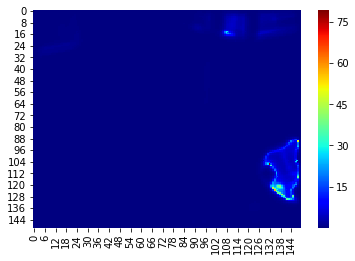

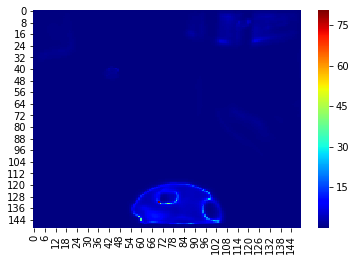

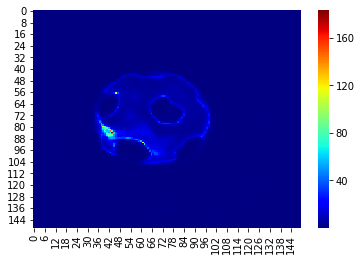

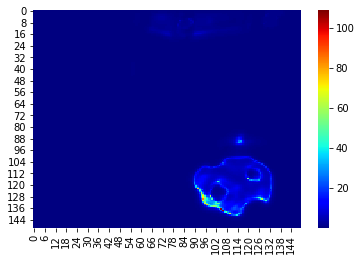

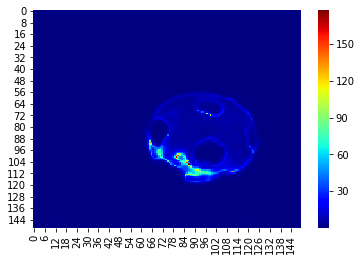

In [130]:
heat_map = sns.heatmap(real_heat_maps[0], cmap = 'jet')
plt.show()
heat_map = sns.heatmap(real_heat_maps[25], cmap = 'jet') 
plt.show()
heat_map = sns.heatmap(real_heat_maps[50], cmap = 'jet') 
plt.show()
heat_map = sns.heatmap(real_heat_maps[75], cmap = 'jet') 
plt.show()
heat_map = sns.heatmap(real_heat_maps[-1], cmap = 'jet') 
plt.show()

### 1.2 Ball (With MiniBatch)

In [84]:
model_path = 'ball_ResED_MiniBatch_1'
centroid_path = 'Centroids/' + model_path + '_centroids' + '.pkl'
video_path = 'Videos/'+model_path+'.avi'

In [85]:
last_out_channel = 3
model = ResED(in_channels=3,
            n_classes=last_out_channel,
            depth=3,
            wf=6,
            padding=1,
            batch_norm=True,
            up_mode='upconv')

In [86]:
print(model)

ResED(
  (down_path): ModuleList(
    (0): ResED_DownBlock(
      (block1): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (block2): Sequential(
        (0): ReLU()
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResED_DownBlock(
      (block1): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (block2): Sequential(
        (0): ReLU()
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): ResED_DownBlock(
      (block1): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (block2): Sequential(
        (0): ReLU()
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (up_path): ModuleList(
    (0): ResED_UpBlock(
      (up): ConvTrans

In [87]:
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
margin = 30
print("margin:", margin)
criterion = TripletLossMiniBatch(margin)
n_epochs = 10
print(ball_img.shape)

margin: 30
torch.Size([1, 3, 115, 115])


In [88]:
model = train_model_with_mini_batch(model, criterion, ball_img, ball_flatten_labels, optimizer, ball_foreground, ball_background, num_epochs=n_epochs, batch_size=256, num_batches=64, get_min_loss=False)

Epochs:  10%|█         | 1/10 [00:01<00:09,  1.04s/it]

loss: 4.022944


Epochs:  20%|██        | 2/10 [00:02<00:08,  1.03s/it]

loss: 1.006705


Epochs:  30%|███       | 3/10 [00:03<00:07,  1.03s/it]

loss: 0.739013


Epochs:  40%|████      | 4/10 [00:04<00:06,  1.04s/it]

loss: 0.848400


Epochs:  50%|█████     | 5/10 [00:05<00:05,  1.02s/it]

loss: 0.690013


Epochs:  60%|██████    | 6/10 [00:06<00:04,  1.03s/it]

loss: 0.380487


Epochs:  70%|███████   | 7/10 [00:07<00:03,  1.04s/it]

loss: 0.875859


Epochs:  80%|████████  | 8/10 [00:08<00:02,  1.05s/it]

loss: 0.647417


Epochs:  90%|█████████ | 9/10 [00:09<00:01,  1.04s/it]

loss: 1.176000


Epochs: 100%|██████████| 10/10 [00:10<00:00,  1.04s/it]

loss: 0.610182
Best val loss: 0.380487


In [89]:
out_features_size = 3
model.eval()

with torch.set_grad_enabled(False):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    img = ball_img.to(device)
    model = model.to(device)
    embeddings = model(img)
embeddings = embeddings.data.cpu().numpy()
print("embeddings.shape:", embeddings.shape) # Datafram will contain 9025 rows and 8 col 
print("flatten_labels.shape:", ball_flatten_labels.shape)

c, w = 0, 0
for i in embeddings:
    if np.array_equal(i, np.array([0.]*out_features_size)):
        c += 1
    else:
        w += 1
print("zeros count:", c)
print("not zeros count:", w)

embeddings.shape: (13225, 3)
flatten_labels.shape: torch.Size([13225])
zeros count: 0
not zeros count: 13225


correct: 13184, wrong: 41, accuracy: 99.68998109640832%


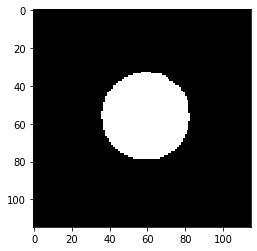

tensor([33, 33, 33,  ..., 78, 78, 78])
tensor([3854, 3963, 3964,  ..., 9034, 9035, 9144])


In [90]:
centroids = get_centroids(embeddings, ball_foreground, ball_background)
# print("centroids:", centroids)
labels_shape = img.shape[-2], img.shape[-1]
heat_map = embeddings_accuracy(embeddings, ball_flatten_labels, labels_shape, centroids, num_classes=2)
# t = .view(-1)
t = torch.tensor(heat_map)
foreground2 = torch.where(t == 1)[0]
plt.imshow(heat_map, cmap=plt.cm.gray)
plt.show()
print(foreground2)
print(ball_foreground)

In [91]:
torch.save(model.state_dict(), 'Models/'+model_path+'.pt')

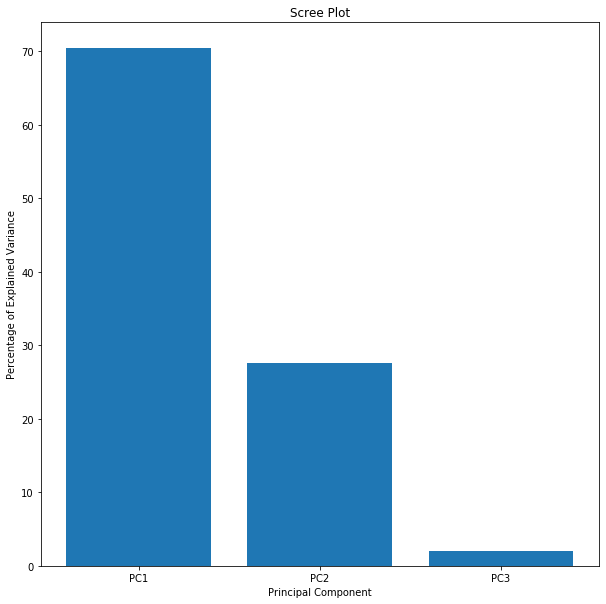

embedding3   -0.667274
embedding2    0.642499
embedding1    0.376751
dtype: float64


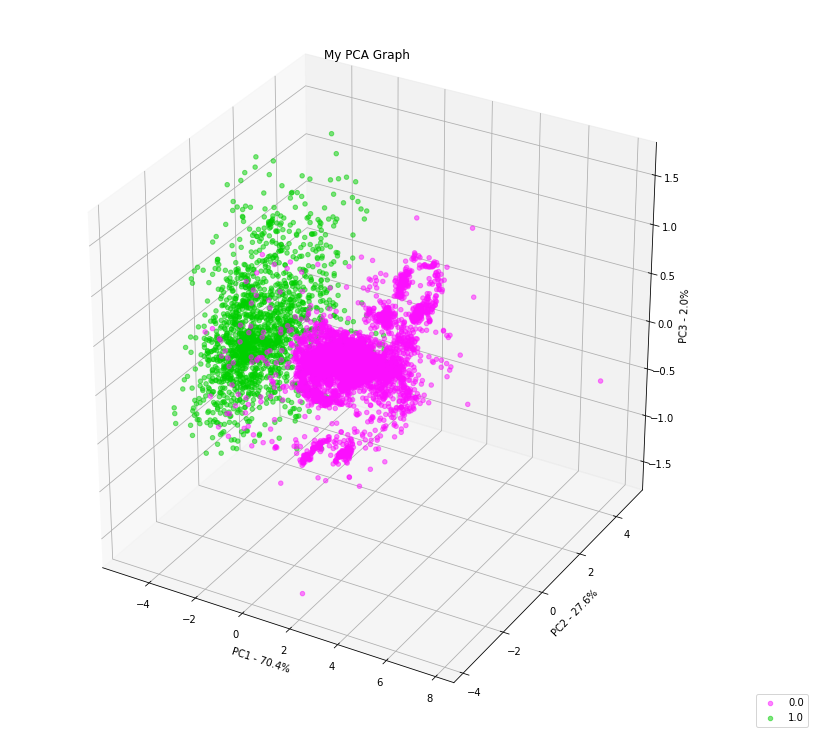

In [92]:
plot_PCA(embeddings, ball_flatten_labels, out_features_size=out_features_size,classes= [0., 1.], colors=['#fc0fff', '#00cf00'], is_3D=True, draw_PCA_per_varc=True, figure_size=(10,10), top_range_loadingfactors=(0, 3))

### save Centroids

In [93]:
model_path = 'ball_ResED_MiniBatch_1'
centroid_path = 'Centroids/' + model_path + '_centroids' + '.pkl'
video_path = 'Videos/'+model_path+'.avi'

In [94]:
last_out_channel = 3
model = ResED(in_channels=3,
            n_classes=last_out_channel,
            depth=3,
            wf=6,
            padding=1,
            batch_norm=True,
            up_mode='upconv')

In [95]:
model.load_state_dict(torch.load('Models/'+model_path+'.pt'))

<All keys matched successfully>

In [96]:
out_features_size = last_out_channel
model.eval()

with torch.set_grad_enabled(False):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    img = ball_img.to(device)
    model = model.to(device)
    embeddings = model(img)
embeddings = embeddings.data.cpu().numpy()
print("embeddings.shape:", embeddings.shape) # Datafram will contain 9025 rows and 8 col 
print("flatten_labels.shape:", ball_flatten_labels.shape)
c, w = 0, 0
for i in embeddings:
    if np.array_equal(i, np.array([0.]*out_features_size)):
        c += 1
    else:
        w += 1
#     print(i)    
print("zeros count:", c)
print("not zeros count:", w)

embeddings.shape: (13225, 3)
flatten_labels.shape: torch.Size([13225])
zeros count: 0
not zeros count: 13225


correct: 13184, wrong: 41, accuracy: 99.68998109640832%


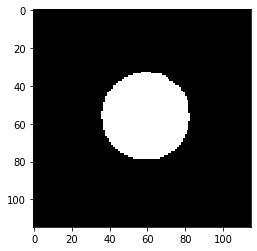

In [97]:
centroids = get_centroids(embeddings, ball_foreground, ball_background)
heat_map = embeddings_accuracy(embeddings, ball_flatten_labels, labels_shape, centroids, num_classes=2)
plt.imshow(heat_map, cmap=plt.cm.gray)
plt.show()

In [98]:
save_centroids(centroid_path, centroids)
centroids_af = load_centroids(centroid_path)
assert np.array_equal(centroids_af, centroids)

### Create Video

In [99]:
model_path = 'ball_ResED_MiniBatch_1'
centroid_path = 'Centroids/' + model_path + '_centroids' + '.pkl'
video_path = 'Videos/'+model_path+'.avi'

last_out_channel = 3
model = ResED(in_channels=3,
            n_classes=last_out_channel,
            depth=3,
            wf=6,
            padding=1,
            batch_norm=True,
            up_mode='upconv')

centroids = load_centroids(centroid_path)
model.load_state_dict(torch.load('Models/'+model_path+'.pt'))

<All keys matched successfully>

In [100]:
frames_step = 3
real_heat_maps = easy_create_real_video(model, centroids, ball_frames_cropped, video_path,ball_width_cropped,
                                        ball_height_cropped, froucc=cv2.VideoWriter_fourcc('M','J','P','G'),
                                        use_gpu=True, fps=10, frames_step=frames_step, num_classes=2,
                                        ret_heat_maps=True, heatmap_path = 'heatmaps/heatmap', img_ext = '.jpg')

Generate Heat Maps: 100%|██████████| 100/100 [01:13<00:00,  1.35it/s]


Time Elapsed (get_heatmaps func) 1m 14s


<Figure size 432x288 with 0 Axes>

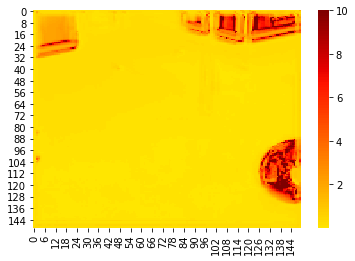

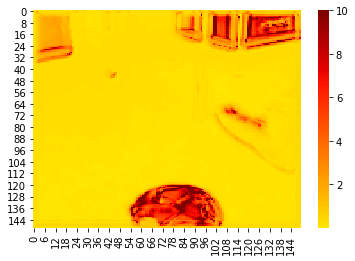

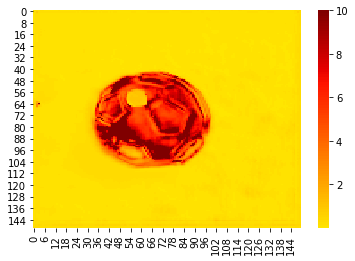

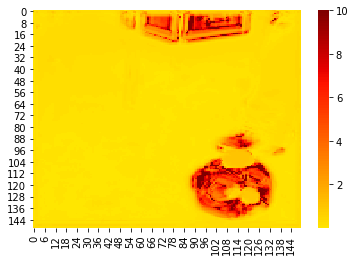

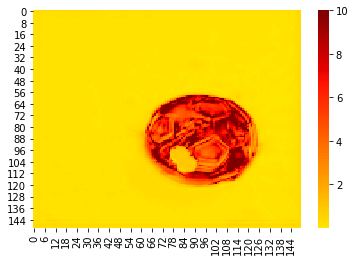

In [102]:
vmin, vmax = -20, 10

heat_map = sns.heatmap(real_heat_maps[0], cmap = 'jet', center=(vmin + vmax) / 2., vmax=vmax)
plt.show()
heat_map = sns.heatmap(real_heat_maps[25], cmap = 'jet', center=(vmin + vmax) / 2., vmax=vmax) 
plt.show()
heat_map = sns.heatmap(real_heat_maps[50], cmap = 'jet', center=(vmin + vmax) / 2., vmax=vmax) 
plt.show()
heat_map = sns.heatmap(real_heat_maps[75], cmap = 'jet', center=(vmin + vmax) / 2., vmax=vmax) 
plt.show()
heat_map = sns.heatmap(real_heat_maps[-1], cmap = 'jet', center=(vmin + vmax) / 2., vmax=vmax)
plt.show()

### 2.1 Cup

In [137]:
model_path = 'cup_ResED_1'
centroid_path = 'Centroids/' + model_path + '_centroids' + '.pkl'
video_path = 'Videos/'+model_path+'.avi'

In [138]:
last_out_channel = 3
model = ResED(in_channels=3,
            n_classes=last_out_channel,
            depth=3,
            wf=6,
            padding=1,
            batch_norm=True,
            up_mode='upconv')

In [139]:
print(model)

ResED(
  (down_path): ModuleList(
    (0): ResED_DownBlock(
      (block1): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (block2): Sequential(
        (0): ReLU()
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResED_DownBlock(
      (block1): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (block2): Sequential(
        (0): ReLU()
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): ResED_DownBlock(
      (block1): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (block2): Sequential(
        (0): ReLU()
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (up_path): ModuleList(
    (0): ResED_UpBlock(
      (up): ConvTrans

In [140]:
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
margin = 300
print("margin:", margin)
criterion = TripletLoss(margin)
n_epochs = 10
print(cup_img.shape)

margin: 300
torch.Size([1, 3, 126, 136])


In [141]:
model = train_model(model, criterion, cup_img, cup_flatten_labels, optimizer, cup_foreground, cup_background, num_epochs=n_epochs, batch_size=95, num_batches=95, get_min_loss=False)

Epochs:  10%|█         | 1/10 [01:39<14:54, 99.41s/it]

loss: 275.470734


Epochs:  20%|██        | 2/10 [03:19<13:15, 99.47s/it]

loss: 136.107422


Epochs:  30%|███       | 3/10 [04:58<11:36, 99.47s/it]

loss: 72.645653


Epochs:  40%|████      | 4/10 [06:38<09:57, 99.53s/it]

loss: 56.221432


Epochs:  50%|█████     | 5/10 [08:17<08:17, 99.56s/it]

loss: 43.029377


Epochs:  60%|██████    | 6/10 [09:57<06:38, 99.55s/it]

loss: 42.988438


Epochs:  70%|███████   | 7/10 [11:36<04:58, 99.56s/it]

loss: 39.922337


Epochs:  80%|████████  | 8/10 [13:16<03:19, 99.58s/it]

loss: 37.767544


Epochs:  90%|█████████ | 9/10 [14:56<01:39, 99.57s/it]

loss: 34.258583


Epochs: 100%|██████████| 10/10 [16:35<00:00, 99.56s/it]

loss: 33.882519
Best val loss: 33.882519


In [142]:
out_features_size = last_out_channel
model.eval()

with torch.set_grad_enabled(False):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    img = cup_img.to(device)
    model = model.to(device)
    embeddings = model(img)
embeddings = embeddings.data.cpu().numpy()
print("embeddings.shape:", embeddings.shape) # Datafram will contain 9025 rows and 8 col 
print("flatten_labels.shape:", cup_flatten_labels.shape)

c, w = 0, 0
for i in embeddings:
    if np.array_equal(i, np.array([0.]*out_features_size)):
        c += 1
    else:
        w += 1
print("zeros count:", c)
print("not zeros count:", w)

embeddings.shape: (17136, 3)
flatten_labels.shape: torch.Size([17136])
zeros count: 0
not zeros count: 17136


correct: 16925, wrong: 211, accuracy: 98.7686741363212%


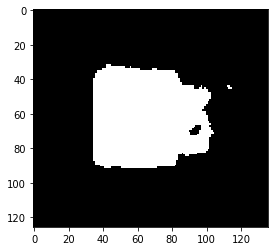

tensor([32, 32, 32,  ..., 91, 91, 91])
tensor([ 4795,  4796,  4797,  ..., 12320, 12321, 12322])


In [143]:
centroids = get_centroids(embeddings, cup_foreground, cup_background)
# print("centroids:", centroids)
labels_shape = img.shape[-2], img.shape[-1]
heat_map = embeddings_accuracy(embeddings, cup_flatten_labels, labels_shape, centroids, num_classes=2)
# t = .view(-1)
t = torch.tensor(heat_map)
foreground2 = torch.where(t == 1)[0]
plt.imshow(heat_map, cmap=plt.cm.gray)
plt.show()
print(foreground2)
print(cup_foreground)

In [144]:
torch.save(model.state_dict(), 'Models/'+model_path+'.pt')

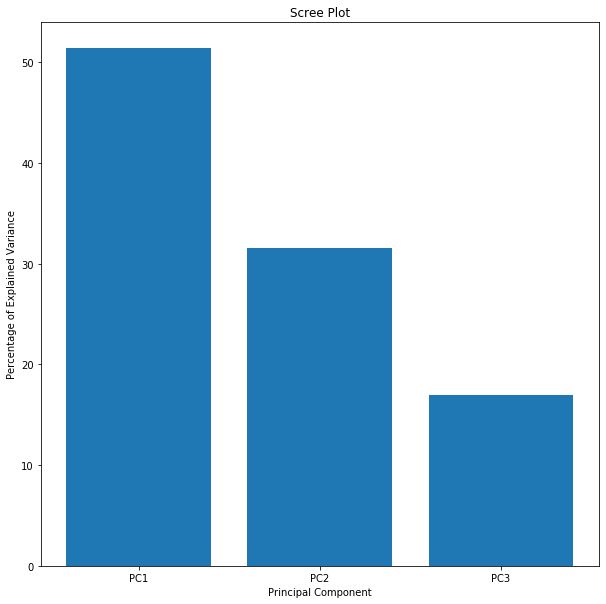

embedding1    0.689175
embedding2    0.547387
embedding3   -0.474769
dtype: float64


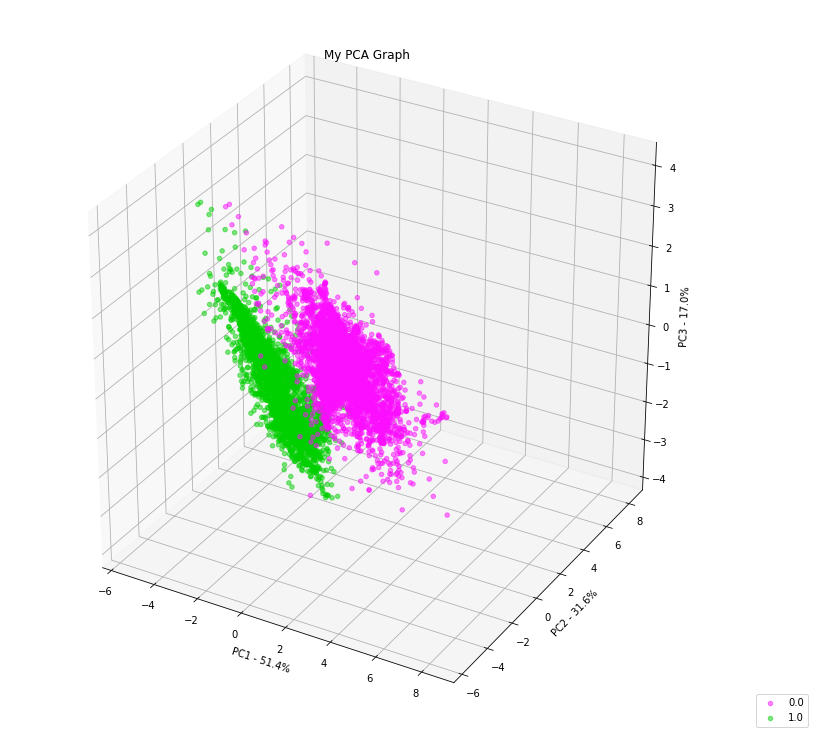

In [145]:
plot_PCA(embeddings, cup_flatten_labels, out_features_size=out_features_size,classes= [0., 1.], colors=['#fc0fff', '#00cf00'], is_3D=True, draw_PCA_per_varc=True, figure_size=(10,10), top_range_loadingfactors=(0, 3))

### save Centroids

In [146]:
model_path = 'cup_ResED_1'
centroid_path = 'Centroids/' + model_path + '_centroids' + '.pkl'
video_path = 'Videos/'+model_path+'.avi'

In [147]:
last_out_channel = 3
model = ResED(in_channels=3,
            n_classes=last_out_channel,
            depth=3,
            wf=6,
            padding=1,
            batch_norm=True,
            up_mode='upconv')

In [148]:
model.load_state_dict(torch.load('Models/'+model_path+'.pt'))

<All keys matched successfully>

In [149]:
out_features_size = last_out_channel
model.eval()

with torch.set_grad_enabled(False):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    img = cup_img.to(device)
    model = model.to(device)
    embeddings = model(img)
embeddings = embeddings.data.cpu().numpy()
print("embeddings.shape:", embeddings.shape) # Datafram will contain 9025 rows and 8 col 
print("flatten_labels.shape:", cup_flatten_labels.shape)
c, w = 0, 0
for i in embeddings:
    if np.array_equal(i, np.array([0.]*out_features_size)):
        c += 1
    else:
        w += 1
#     print(i)    
print("zeros count:", c)
print("not zeros count:", w)

embeddings.shape: (17136, 3)
flatten_labels.shape: torch.Size([17136])
zeros count: 0
not zeros count: 17136


correct: 16925, wrong: 211, accuracy: 98.7686741363212%


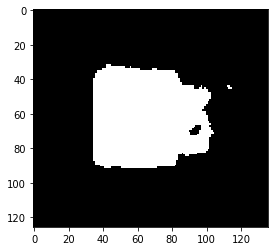

In [150]:
centroids = get_centroids(embeddings, cup_foreground, cup_background)
heat_map = embeddings_accuracy(embeddings, cup_flatten_labels, labels_shape, centroids, num_classes=2)
plt.imshow(heat_map, cmap=plt.cm.gray)
plt.show()

In [151]:
save_centroids(centroid_path, centroids)
centroids_af = load_centroids(centroid_path)
assert np.array_equal(centroids_af, centroids)

### Create Video

In [152]:
model_path = 'cup_ResED_1'
centroid_path = 'Centroids/' + model_path + '_centroids' + '.pkl'
video_path = 'Videos/'+model_path+'.avi'

last_out_channel = 3
model = ResED(in_channels=3,
            n_classes=last_out_channel,
            depth=3,
            wf=6,
            padding=1,
            batch_norm=True,
            up_mode='upconv')

centroids = load_centroids(centroid_path)
model.load_state_dict(torch.load('Models/'+model_path+'.pt'))

<All keys matched successfully>

In [153]:
frames_step = 3
real_heat_maps = easy_create_real_video(model, centroids, cup_frames_cropped, video_path, cup_width_cropped,
                                        cup_height_cropped, froucc=cv2.VideoWriter_fourcc('M','J','P','G'),
                                        use_gpu=True, fps=10, frames_step=frames_step, num_classes=2,
                                        ret_heat_maps=True, heatmap_path = 'heatmaps/heatmap', img_ext = '.jpg')

Generate Heat Maps: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Time Elapsed (get_heatmaps func) 1m 17s


<Figure size 432x288 with 0 Axes>

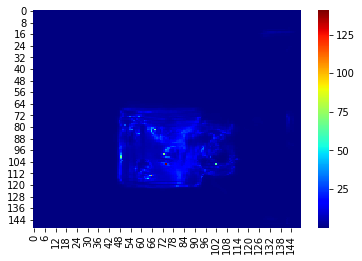

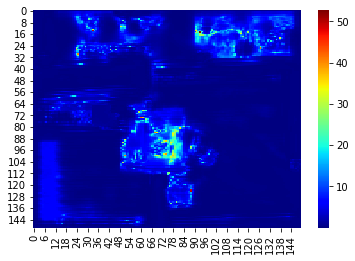

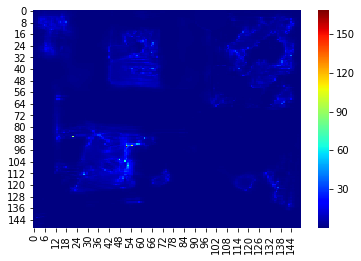

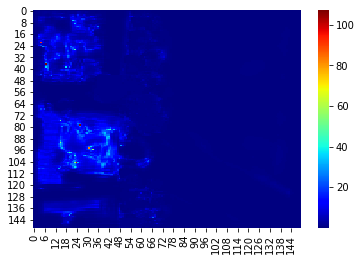

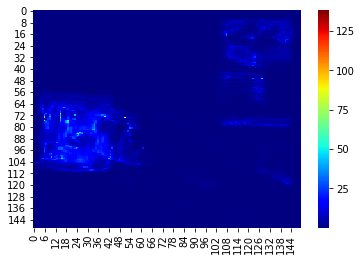

In [154]:
heat_map = sns.heatmap(real_heat_maps[0], cmap = 'jet')
plt.show()
heat_map = sns.heatmap(real_heat_maps[25], cmap = 'jet') 
plt.show()
heat_map = sns.heatmap(real_heat_maps[50], cmap = 'jet') 
plt.show()
heat_map = sns.heatmap(real_heat_maps[75], cmap = 'jet') 
plt.show()
heat_map = sns.heatmap(real_heat_maps[-1], cmap = 'jet') 
plt.show()

### 2.2. Cup

In [186]:
model_path = 'cup_ResED_2'
centroid_path = 'Centroids/' + model_path + '_centroids' + '.pkl'
video_path = 'Videos/'+model_path+'.avi'

In [187]:
last_out_channel = 3
model = ResED(in_channels=3,
            n_classes=last_out_channel,
            depth=3,
            wf=6,
            padding=1,
            batch_norm=True,
            up_mode='upconv')

In [188]:
print(model)

ResED(
  (down_path): ModuleList(
    (0): ResED_DownBlock(
      (block1): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (block2): Sequential(
        (0): ReLU()
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResED_DownBlock(
      (block1): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (block2): Sequential(
        (0): ReLU()
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): ResED_DownBlock(
      (block1): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (block2): Sequential(
        (0): ReLU()
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (up_path): ModuleList(
    (0): ResED_UpBlock(
      (up): ConvTrans

In [189]:
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
margin = 300
print("margin:", margin)
criterion = TripletLoss(margin)
n_epochs = 10
print(cup_img.shape)

margin: 300
torch.Size([1, 3, 126, 136])


In [205]:
model.load_state_dict(torch.load('Models/'+'cup_ResED_1'+'.pt'))

<All keys matched successfully>

In [206]:
model = train_model(model, criterion, cup_img, cup_flatten_labels, optimizer, cup_foreground, cup_background, num_epochs=n_epochs, batch_size=95, num_batches=95, get_min_loss=False)

Epochs:  20%|██        | 1/5 [01:39<06:38, 99.66s/it]

loss: 28.173805


Epochs:  40%|████      | 2/5 [03:19<04:58, 99.66s/it]

loss: 26.234980


Epochs:  60%|██████    | 3/5 [04:59<03:19, 99.67s/it]

loss: 25.119982


Epochs:  80%|████████  | 4/5 [06:38<01:39, 99.66s/it]

loss: 26.065506


Epochs: 100%|██████████| 5/5 [08:18<00:00, 99.64s/it]

loss: 28.206926
Best val loss: 25.119982


In [207]:
out_features_size = last_out_channel
model.eval()

with torch.set_grad_enabled(False):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    img = cup_img.to(device)
    model = model.to(device)
    embeddings = model(img)
embeddings = embeddings.data.cpu().numpy()
print("embeddings.shape:", embeddings.shape) # Datafram will contain 9025 rows and 8 col 
print("flatten_labels.shape:", cup_flatten_labels.shape)

c, w = 0, 0
for i in embeddings:
    if np.array_equal(i, np.array([0.]*out_features_size)):
        c += 1
    else:
        w += 1
print("zeros count:", c)
print("not zeros count:", w)

embeddings.shape: (17136, 3)
flatten_labels.shape: torch.Size([17136])
zeros count: 0
not zeros count: 17136


correct: 16996, wrong: 140, accuracy: 99.18300653594771%


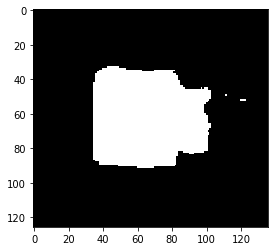

tensor([33, 33, 33,  ..., 91, 91, 91])
tensor([ 4795,  4796,  4797,  ..., 12320, 12321, 12322])


In [208]:
centroids = get_centroids(embeddings, cup_foreground, cup_background)
# print("centroids:", centroids)
labels_shape = img.shape[-2], img.shape[-1]
heat_map = embeddings_accuracy(embeddings, cup_flatten_labels, labels_shape, centroids, num_classes=2)
# t = .view(-1)
t = torch.tensor(heat_map)
foreground2 = torch.where(t == 1)[0]
plt.imshow(heat_map, cmap=plt.cm.gray)
plt.show()
print(foreground2)
print(cup_foreground)

In [209]:
torch.save(model.state_dict(), 'Models/'+model_path+'.pt')

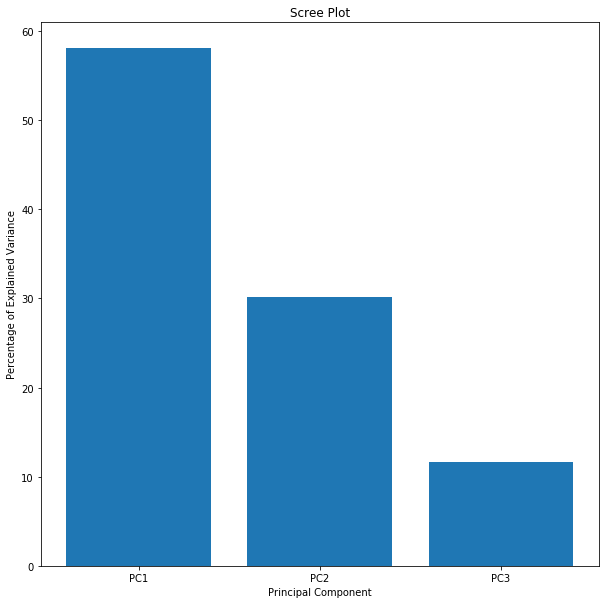

embedding2   -0.677567
embedding1   -0.639333
embedding3   -0.363533
dtype: float64


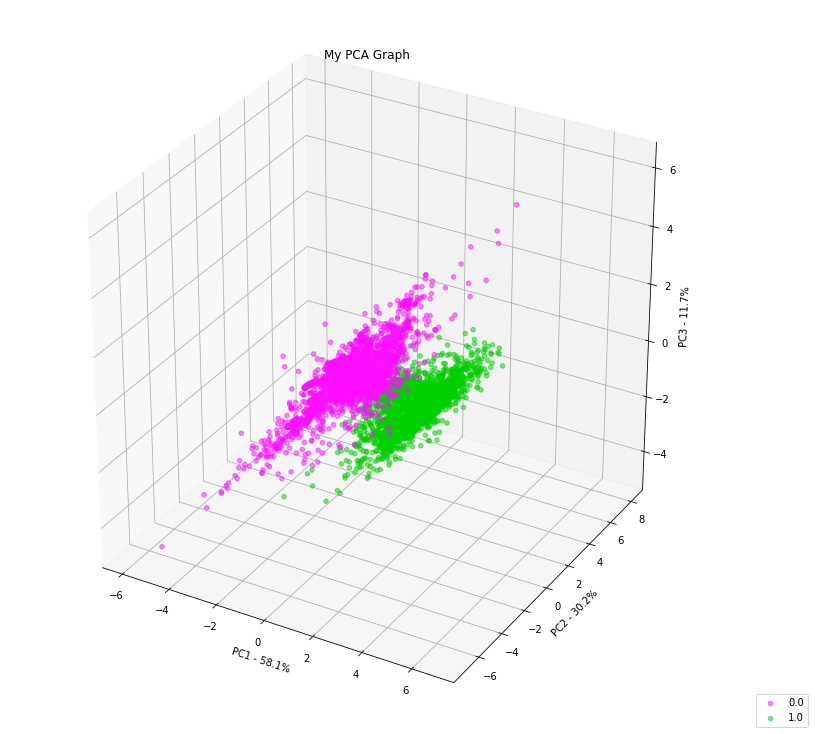

In [210]:
plot_PCA(embeddings, cup_flatten_labels, out_features_size=out_features_size,classes= [0., 1.], colors=['#fc0fff', '#00cf00'], is_3D=True, draw_PCA_per_varc=True, figure_size=(10,10), top_range_loadingfactors=(0, 3))

### save Centroids

In [211]:
model_path = 'cup_ResED_2'
centroid_path = 'Centroids/' + model_path + '_centroids' + '.pkl'
video_path = 'Videos/'+model_path+'.avi'

In [212]:
last_out_channel = 3
model = ResED(in_channels=3,
            n_classes=last_out_channel,
            depth=3,
            wf=6,
            padding=1,
            batch_norm=True,
            up_mode='upconv')

In [213]:
model.load_state_dict(torch.load('Models/'+model_path+'.pt'))

<All keys matched successfully>

In [214]:
out_features_size = last_out_channel
model.eval()

with torch.set_grad_enabled(False):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    img = cup_img.to(device)
    model = model.to(device)
    embeddings = model(img)
embeddings = embeddings.data.cpu().numpy()
print("embeddings.shape:", embeddings.shape) # Datafram will contain 9025 rows and 8 col 
print("flatten_labels.shape:", cup_flatten_labels.shape)
c, w = 0, 0
for i in embeddings:
    if np.array_equal(i, np.array([0.]*out_features_size)):
        c += 1
    else:
        w += 1
#     print(i)    
print("zeros count:", c)
print("not zeros count:", w)

embeddings.shape: (17136, 3)
flatten_labels.shape: torch.Size([17136])
zeros count: 0
not zeros count: 17136


correct: 16996, wrong: 140, accuracy: 99.18300653594771%


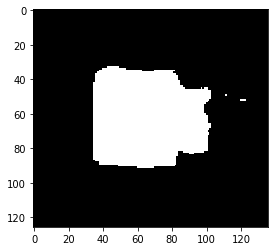

In [215]:
centroids = get_centroids(embeddings, cup_foreground, cup_background)
heat_map = embeddings_accuracy(embeddings, cup_flatten_labels, labels_shape, centroids, num_classes=2)
plt.imshow(heat_map, cmap=plt.cm.gray)
plt.show()

In [216]:
save_centroids(centroid_path, centroids)
centroids_af = load_centroids(centroid_path)
assert np.array_equal(centroids_af, centroids)

### Create Video

In [217]:
model_path = 'cup_ResED_2'
centroid_path = 'Centroids/' + model_path + '_centroids' + '.pkl'
video_path = 'Videos/'+model_path+'.avi'

last_out_channel = 3
model = ResED(in_channels=3,
            n_classes=last_out_channel,
            depth=3,
            wf=6,
            padding=1,
            batch_norm=True,
            up_mode='upconv')

centroids = load_centroids(centroid_path)
model.load_state_dict(torch.load('Models/'+model_path+'.pt'))

<All keys matched successfully>

In [218]:
frames_step = 3
real_heat_maps = easy_create_real_video(model, centroids, cup_frames_cropped, video_path, cup_width_cropped,
                                        cup_height_cropped, froucc=cv2.VideoWriter_fourcc('M','J','P','G'),
                                        use_gpu=True, fps=10, frames_step=frames_step, num_classes=2,
                                        ret_heat_maps=True, heatmap_path = 'heatmaps/heatmap', img_ext = '.jpg')

Generate Heat Maps: 100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


Time Elapsed (get_heatmaps func) 1m 17s


<Figure size 432x288 with 0 Axes>

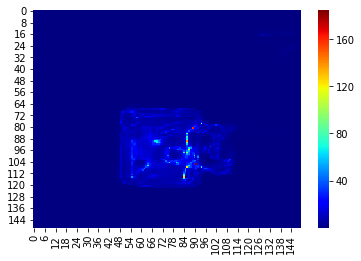

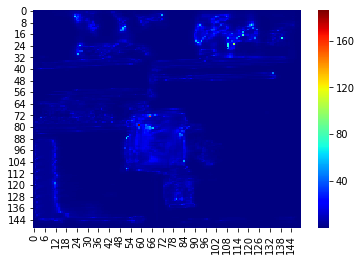

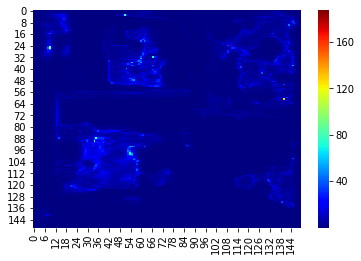

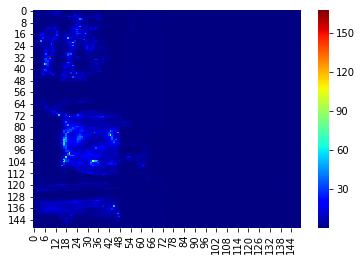

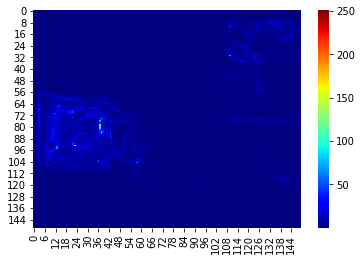

In [219]:
heat_map = sns.heatmap(real_heat_maps[0], cmap = 'jet')
plt.show()
heat_map = sns.heatmap(real_heat_maps[25], cmap = 'jet') 
plt.show()
heat_map = sns.heatmap(real_heat_maps[50], cmap = 'jet') 
plt.show()
heat_map = sns.heatmap(real_heat_maps[75], cmap = 'jet') 
plt.show()
heat_map = sns.heatmap(real_heat_maps[-1], cmap = 'jet') 
plt.show()

### 2.3. Cup (With MiniBatch)

In [60]:
model_path = 'cup_ResED_MiniBatch_1'
centroid_path = 'Centroids/' + model_path + '_centroids' + '.pkl'
video_path = 'Videos/'+model_path+'.avi'

In [61]:
last_out_channel = 3
model = ResED(in_channels=3,
            n_classes=last_out_channel,
            depth=3,
            wf=6,
            padding=1,
            batch_norm=True,
            up_mode='upconv')

In [62]:
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
margin = 30
print("margin:", margin)
criterion = TripletLossMiniBatch(margin)
n_epochs = 10
print(cup_img.shape)

margin: 30
torch.Size([1, 3, 126, 136])


In [63]:
model = train_model_with_mini_batch(model, criterion, cup_img, cup_flatten_labels, optimizer, cup_foreground, cup_background, num_epochs=n_epochs, batch_size=265, num_batches=64, get_min_loss=False)

Epochs:  10%|█         | 1/10 [00:01<00:10,  1.18s/it]

loss: 13.719041


Epochs:  20%|██        | 2/10 [00:02<00:09,  1.17s/it]

loss: 2.529787


Epochs:  30%|███       | 3/10 [00:03<00:08,  1.17s/it]

loss: 1.285963


Epochs:  40%|████      | 4/10 [00:04<00:06,  1.16s/it]

loss: 1.333680


Epochs:  50%|█████     | 5/10 [00:05<00:05,  1.17s/it]

loss: 1.101509


Epochs:  60%|██████    | 6/10 [00:06<00:04,  1.17s/it]

loss: 1.334614


Epochs:  70%|███████   | 7/10 [00:08<00:03,  1.16s/it]

loss: 1.021734


Epochs:  80%|████████  | 8/10 [00:09<00:02,  1.16s/it]

loss: 0.810478


Epochs:  90%|█████████ | 9/10 [00:10<00:01,  1.15s/it]

loss: 0.635713


Epochs: 100%|██████████| 10/10 [00:11<00:00,  1.16s/it]

loss: 0.694752
Best val loss: 0.635713


In [64]:
out_features_size = last_out_channel
model.eval()

with torch.set_grad_enabled(False):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    img = cup_img.to(device)
    model = model.to(device)
    embeddings = model(img)
embeddings = embeddings.data.cpu().numpy()
print("embeddings.shape:", embeddings.shape) # Datafram will contain 9025 rows and 8 col 
print("flatten_labels.shape:", cup_flatten_labels.shape)

c, w = 0, 0
for i in embeddings:
    if np.array_equal(i, np.array([0.]*out_features_size)):
        c += 1
    else:
        w += 1
print("zeros count:", c)
print("not zeros count:", w)

embeddings.shape: (17136, 3)
flatten_labels.shape: torch.Size([17136])
zeros count: 0
not zeros count: 17136


correct: 17021, wrong: 115, accuracy: 99.32889822595705%


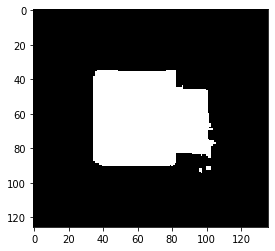

tensor([35, 35, 35,  ..., 93, 93, 94])
tensor([ 4795,  4796,  4797,  ..., 12320, 12321, 12322])


In [65]:
centroids = get_centroids(embeddings, cup_foreground, cup_background)
# print("centroids:", centroids)
labels_shape = img.shape[-2], img.shape[-1]
heat_map = embeddings_accuracy(embeddings, cup_flatten_labels, labels_shape, centroids, num_classes=2)
# t = .view(-1)
t = torch.tensor(heat_map)
foreground2 = torch.where(t == 1)[0]
plt.imshow(heat_map, cmap=plt.cm.gray)
plt.show()
print(foreground2)
print(cup_foreground)

In [66]:
torch.save(model.state_dict(), 'Models/'+model_path+'.pt')

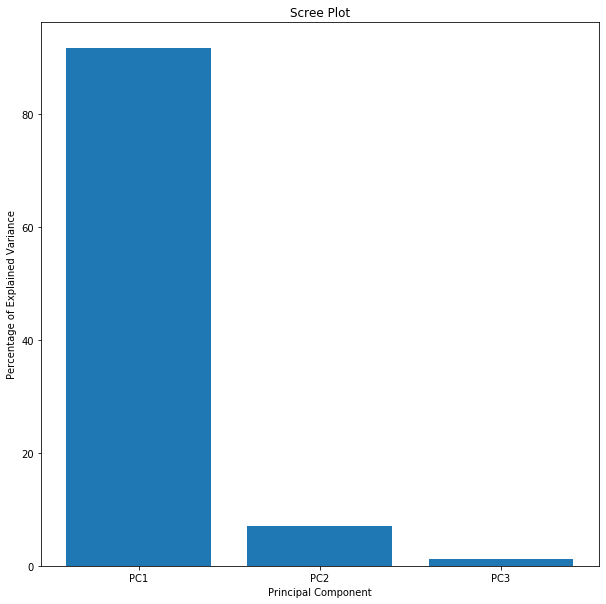

embedding2    0.590557
embedding1   -0.583147
embedding3   -0.557837
dtype: float64


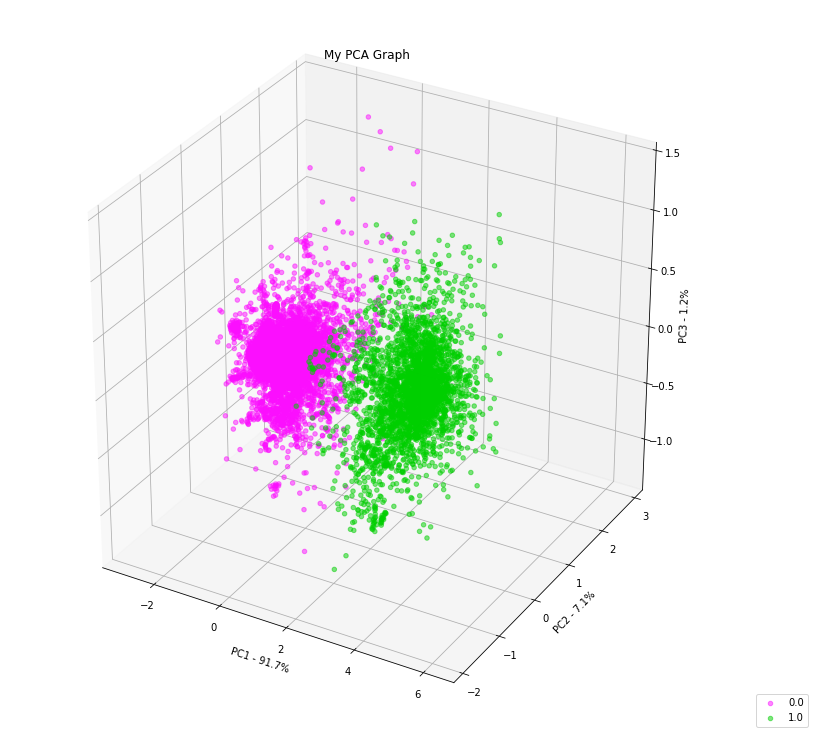

In [67]:
plot_PCA(embeddings, cup_flatten_labels, out_features_size=out_features_size,classes= [0., 1.], colors=['#fc0fff', '#00cf00'], is_3D=True, draw_PCA_per_varc=True, figure_size=(10,10), top_range_loadingfactors=(0, 3))

### save Centroids

In [68]:
model_path = 'cup_ResED_MiniBatch_1'
centroid_path = 'Centroids/' + model_path + '_centroids' + '.pkl'
video_path = 'Videos/'+model_path+'.avi'

In [69]:
last_out_channel = 3
model = ResED(in_channels=3,
            n_classes=last_out_channel,
            depth=3,
            wf=6,
            padding=1,
            batch_norm=True,
            up_mode='upconv')

In [70]:
model.load_state_dict(torch.load('Models/'+model_path+'.pt'))

<All keys matched successfully>

In [71]:
out_features_size = last_out_channel
model.eval()

with torch.set_grad_enabled(False):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    img = cup_img.to(device)
    model = model.to(device)
    embeddings = model(img)
embeddings = embeddings.data.cpu().numpy()
print("embeddings.shape:", embeddings.shape) # Datafram will contain 9025 rows and 8 col 
print("flatten_labels.shape:", cup_flatten_labels.shape)
c, w = 0, 0
for i in embeddings:
    if np.array_equal(i, np.array([0.]*out_features_size)):
        c += 1
    else:
        w += 1
#     print(i)    
print("zeros count:", c)
print("not zeros count:", w)

embeddings.shape: (17136, 3)
flatten_labels.shape: torch.Size([17136])
zeros count: 0
not zeros count: 17136


correct: 17021, wrong: 115, accuracy: 99.32889822595705%


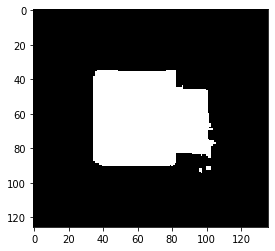

In [72]:
centroids = get_centroids(embeddings, cup_foreground, cup_background)
heat_map = embeddings_accuracy(embeddings, cup_flatten_labels, labels_shape, centroids, num_classes=2)
plt.imshow(heat_map, cmap=plt.cm.gray)
plt.show()

In [73]:
save_centroids(centroid_path, centroids)
centroids_af = load_centroids(centroid_path)
assert np.array_equal(centroids_af, centroids)

### Create Video

In [74]:
model_path = 'cup_ResED_MiniBatch_1'
centroid_path = 'Centroids/' + model_path + '_centroids' + '.pkl'
video_path = 'Videos/'+model_path+'.avi'

last_out_channel = 3
model = ResED(in_channels=3,
            n_classes=last_out_channel,
            depth=3,
            wf=6,
            padding=1,
            batch_norm=True,
            up_mode='upconv')

centroids = load_centroids(centroid_path)
model.load_state_dict(torch.load('Models/'+model_path+'.pt'))

<All keys matched successfully>

In [75]:
frames_step = 3
real_heat_maps = easy_create_real_video(model, centroids, cup_frames_cropped, video_path, cup_width_cropped,
                                        cup_height_cropped, froucc=cv2.VideoWriter_fourcc('M','J','P','G'),
                                        use_gpu=True, fps=10, frames_step=frames_step, num_classes=2,
                                        ret_heat_maps=True, heatmap_path = 'heatmaps/heatmap', img_ext = '.jpg')

Generate Heat Maps: 100%|██████████| 100/100 [01:13<00:00,  1.35it/s]


Time Elapsed (get_heatmaps func) 1m 14s


<Figure size 432x288 with 0 Axes>

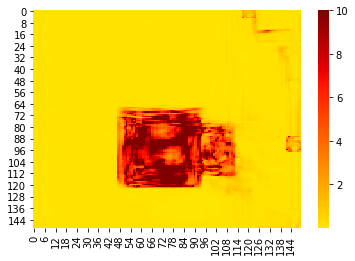

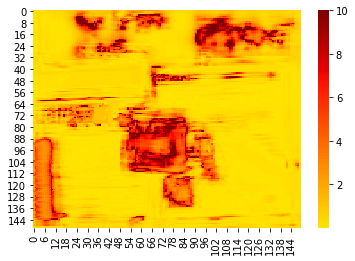

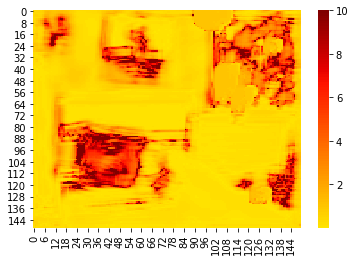

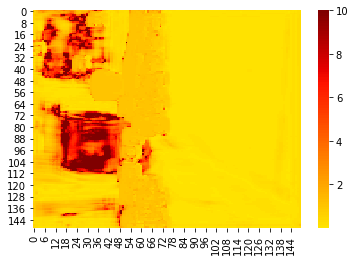

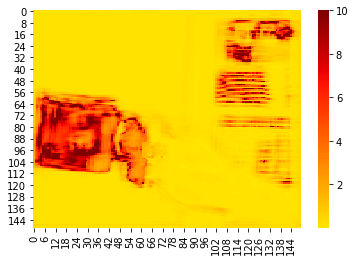

In [76]:
vmin, vmax = -20, 10

heat_map = sns.heatmap(real_heat_maps[0], cmap = 'jet', center=(vmin + vmax) / 2., vmax=vmax)
plt.show()
heat_map = sns.heatmap(real_heat_maps[25], cmap = 'jet', center=(vmin + vmax) / 2., vmax=vmax) 
plt.show()
heat_map = sns.heatmap(real_heat_maps[50], cmap = 'jet', center=(vmin + vmax) / 2., vmax=vmax) 
plt.show()
heat_map = sns.heatmap(real_heat_maps[75], cmap = 'jet', center=(vmin + vmax) / 2., vmax=vmax) 
plt.show()
heat_map = sns.heatmap(real_heat_maps[-1], cmap = 'jet', center=(vmin + vmax) / 2., vmax=vmax)
plt.show()

### 3.1. Person

In [155]:
model_path = 'person_ResED_1'
centroid_path = 'Centroids/' + model_path + '_centroids' + '.pkl'
video_path = 'Videos/'+model_path+'.avi'

In [158]:
last_out_channel = 3
model = ResED(in_channels=3,
            n_classes=last_out_channel,
            depth=3,
            wf=6,
            padding=1,
            batch_norm=True,
            up_mode='upconv')

In [159]:
print(model)

ResED(
  (down_path): ModuleList(
    (0): ResED_DownBlock(
      (block1): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (block2): Sequential(
        (0): ReLU()
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResED_DownBlock(
      (block1): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (block2): Sequential(
        (0): ReLU()
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): ResED_DownBlock(
      (block1): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (block2): Sequential(
        (0): ReLU()
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (up_path): ModuleList(
    (0): ResED_UpBlock(
      (up): ConvTrans

In [160]:
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
margin = 100
print("margin:", margin)
criterion = TripletLoss(margin)
n_epochs = 10
print(person_img.shape)

margin: 100
torch.Size([1, 3, 202, 113])


In [161]:
model = train_model(model, criterion, person_img, person_flatten_labels, optimizer, person_foreground, person_background, num_epochs=n_epochs, batch_size=95, num_batches=95, get_min_loss=False)

Epochs:  10%|█         | 1/10 [02:21<21:09, 141.08s/it]

loss: 124.762215


Epochs:  20%|██        | 2/10 [04:42<18:48, 141.10s/it]

loss: 67.159531


Epochs:  30%|███       | 3/10 [07:03<16:27, 141.11s/it]

loss: 43.390587


Epochs:  40%|████      | 4/10 [09:24<14:06, 141.13s/it]

loss: 37.503689


Epochs:  50%|█████     | 5/10 [11:45<11:45, 141.13s/it]

loss: 31.534363


Epochs:  60%|██████    | 6/10 [14:06<09:24, 141.13s/it]

loss: 30.787506


Epochs:  70%|███████   | 7/10 [16:28<07:03, 141.15s/it]

loss: 27.162624


Epochs:  80%|████████  | 8/10 [18:49<04:42, 141.15s/it]

loss: 26.524487


Epochs:  90%|█████████ | 9/10 [21:10<02:21, 141.23s/it]

loss: 26.567348


Epochs: 100%|██████████| 10/10 [23:32<00:00, 141.20s/it]

loss: 24.963165
Best val loss: 24.963165


In [162]:
out_features_size = last_out_channel
model.eval()

with torch.set_grad_enabled(False):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    img = person_img.to(device)
    model = model.to(device)
    embeddings = model(img)
embeddings = embeddings.data.cpu().numpy()
print("embeddings.shape:", embeddings.shape) # Datafram will contain 9025 rows and 8 col 
print("flatten_labels.shape:", person_flatten_labels.shape)

c, w = 0, 0
for i in embeddings:
    if np.array_equal(i, np.array([0.]*out_features_size)):
        c += 1
    else:
        w += 1
print("zeros count:", c)
print("not zeros count:", w)

embeddings.shape: (22826, 3)
flatten_labels.shape: torch.Size([22826])
zeros count: 0
not zeros count: 22826


correct: 21936, wrong: 890, accuracy: 96.10093752738106%


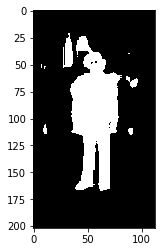

tensor([ 21,  21,  22,  ..., 167, 167, 167])
tensor([ 4350,  4459,  4460,  ..., 18939, 18940, 18941])


In [163]:
centroids = get_centroids(embeddings, person_foreground, person_background)
# print("centroids:", centroids)
labels_shape = img.shape[-2], img.shape[-1]
heat_map = embeddings_accuracy(embeddings, person_flatten_labels, labels_shape, centroids, num_classes=2)
# t = .view(-1)
t = torch.tensor(heat_map)
foreground2 = torch.where(t == 1)[0]
plt.imshow(heat_map, cmap=plt.cm.gray)
plt.show()
print(foreground2)
print(person_foreground)

In [164]:
torch.save(model.state_dict(), 'Models/'+model_path+'.pt')

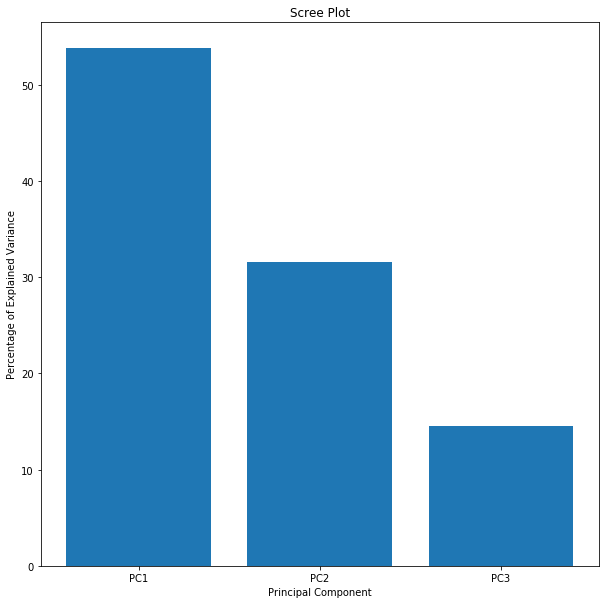

embedding2    0.687939
embedding1    0.656955
embedding3   -0.308466
dtype: float64


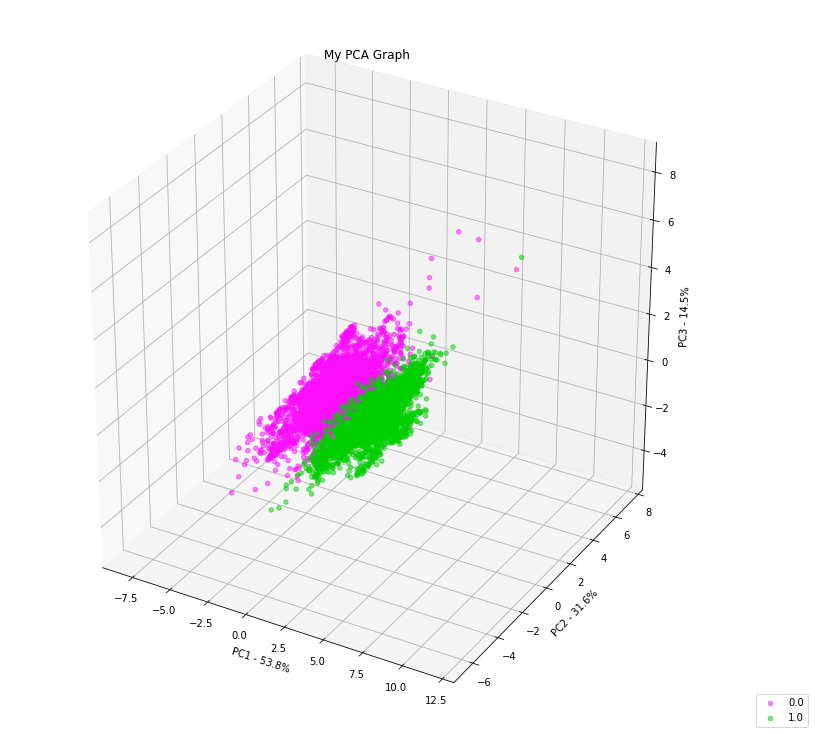

In [165]:
plot_PCA(embeddings, person_flatten_labels, out_features_size=out_features_size,classes= [0., 1.], colors=['#fc0fff', '#00cf00'], is_3D=True, draw_PCA_per_varc=True, figure_size=(10,10), top_range_loadingfactors=(0, 3))

### save Centroids

In [166]:
model_path = 'person_ResED_1'
centroid_path = 'Centroids/' + model_path + '_centroids' + '.pkl'
video_path = 'Videos/'+model_path+'.avi'

In [167]:
last_out_channel = 3
model = ResED(in_channels=3,
            n_classes=last_out_channel,
            depth=3,
            wf=6,
            padding=1,
            batch_norm=True,
            up_mode='upconv')

In [168]:
model.load_state_dict(torch.load('Models/'+model_path+'.pt'))

<All keys matched successfully>

In [169]:
out_features_size = last_out_channel
model.eval()

with torch.set_grad_enabled(False):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    img = person_img.to(device)
    model = model.to(device)
    embeddings = model(img)
embeddings = embeddings.data.cpu().numpy()
print("embeddings.shape:", embeddings.shape) # Datafram will contain 9025 rows and 8 col 
print("flatten_labels.shape:", person_flatten_labels.shape)
c, w = 0, 0
for i in embeddings:
    if np.array_equal(i, np.array([0.]*out_features_size)):
        c += 1
    else:
        w += 1
#     print(i)    
print("zeros count:", c)
print("not zeros count:", w)

embeddings.shape: (22826, 3)
flatten_labels.shape: torch.Size([22826])
zeros count: 0
not zeros count: 22826


correct: 21936, wrong: 890, accuracy: 96.10093752738106%


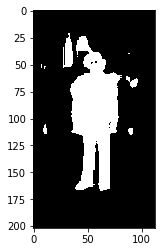

In [170]:
centroids = get_centroids(embeddings, person_foreground, person_background)
heat_map = embeddings_accuracy(embeddings, person_flatten_labels, labels_shape, centroids, num_classes=2)
plt.imshow(heat_map, cmap=plt.cm.gray)
plt.show()

In [171]:
save_centroids(centroid_path, centroids)
centroids_af = load_centroids(centroid_path)
assert np.array_equal(centroids_af, centroids)

### Create Video

In [172]:
model_path = 'person_ResED_1'
centroid_path = 'Centroids/' + model_path + '_centroids' + '.pkl'
video_path = 'Videos/'+model_path+'.avi'

last_out_channel = 3
model = ResED(in_channels=3,
            n_classes=last_out_channel,
            depth=3,
            wf=6,
            padding=1,
            batch_norm=True,
            up_mode='upconv')

centroids = load_centroids(centroid_path)
model.load_state_dict(torch.load('Models/'+model_path+'.pt'))

<All keys matched successfully>

In [173]:
frames_step = 3
real_heat_maps = easy_create_real_video(model, centroids, person_frames_cropped, video_path, person_width_cropped,
                                        person_height_cropped, froucc=cv2.VideoWriter_fourcc('M','J','P','G'),
                                        use_gpu=True, fps=10, frames_step=frames_step, num_classes=2,
                                        ret_heat_maps=True, heatmap_path = 'heatmaps/heatmap', img_ext = '.jpg')

Generate Heat Maps: 100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


Time Elapsed (get_heatmaps func) 1m 17s


<Figure size 432x288 with 0 Axes>

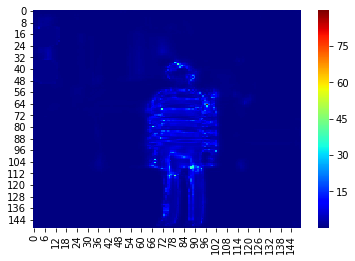

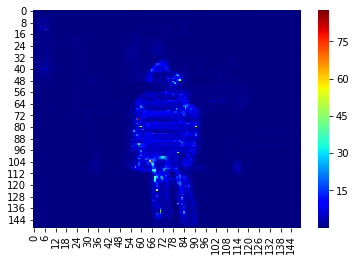

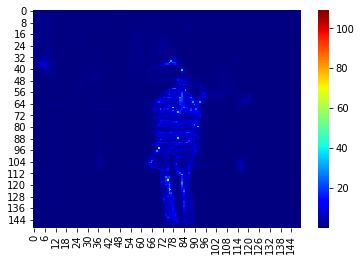

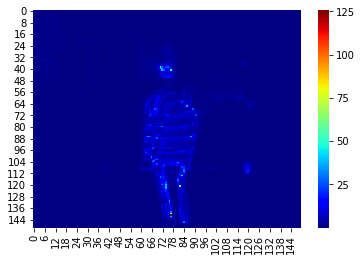

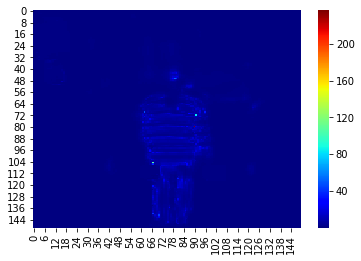

In [174]:
heat_map = sns.heatmap(real_heat_maps[0], cmap = 'jet')
plt.show()
heat_map = sns.heatmap(real_heat_maps[25], cmap = 'jet') 
plt.show()
heat_map = sns.heatmap(real_heat_maps[50], cmap = 'jet') 
plt.show()
heat_map = sns.heatmap(real_heat_maps[75], cmap = 'jet') 
plt.show()
heat_map = sns.heatmap(real_heat_maps[-1], cmap = 'jet') 
plt.show()

## 3.2 Person (With MiniBatch)

In [12]:
model_path = 'person_ResED_Minibatch_1'
centroid_path = 'Centroids/' + model_path + '_centroids' + '.pkl'
video_path = 'Videos/'+model_path+'.avi'

last_out_channel = 3
model = ResED(in_channels=3,
            n_classes=last_out_channel,
            depth=3,
            wf=6,
            padding=1,
            batch_norm=True,
            up_mode='upconv')

In [13]:
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
margin = 10
print("margin:", margin)
criterion = TripletLossMiniBatch(margin)
n_epochs = 10
print(person_img.shape)

margin: 10
torch.Size([1, 3, 202, 113])


In [14]:
model = train_model_with_mini_batch(model, criterion, person_img, person_flatten_labels, optimizer, person_foreground, person_background, num_epochs=n_epochs, batch_size=256, num_batches=64, get_min_loss=False)

Epochs:  10%|█         | 1/10 [00:01<00:13,  1.47s/it]

loss: 11.659855


Epochs:  20%|██        | 2/10 [00:02<00:11,  1.41s/it]

loss: 2.417845


Epochs:  30%|███       | 3/10 [00:04<00:09,  1.37s/it]

loss: 1.315047


Epochs:  40%|████      | 4/10 [00:05<00:08,  1.35s/it]

loss: 1.388119


Epochs:  50%|█████     | 5/10 [00:06<00:06,  1.32s/it]

loss: 1.364138


Epochs:  60%|██████    | 6/10 [00:07<00:05,  1.33s/it]

loss: 1.006442


Epochs:  70%|███████   | 7/10 [00:09<00:03,  1.31s/it]

loss: 0.995923


Epochs:  80%|████████  | 8/10 [00:10<00:02,  1.30s/it]

loss: 0.920461


Epochs:  90%|█████████ | 9/10 [00:11<00:01,  1.29s/it]

loss: 1.124023


Epochs: 100%|██████████| 10/10 [00:13<00:00,  1.30s/it]

loss: 0.938874
Best val loss: 0.920461


In [15]:
out_features_size = last_out_channel
model.eval()

with torch.set_grad_enabled(False):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    img = person_img.to(device)
    model = model.to(device)
    embeddings = model(img)
embeddings = embeddings.data.cpu().numpy()
print("embeddings.shape:", embeddings.shape) # Datafram will contain 9025 rows and 8 col 
print("flatten_labels.shape:", person_flatten_labels.shape)

c, w = 0, 0
for i in embeddings:
    if np.array_equal(i, np.array([0.]*out_features_size)):
        c += 1
    else:
        w += 1
print("zeros count:", c)
print("not zeros count:", w)

embeddings.shape: (22826, 3)
flatten_labels.shape: torch.Size([22826])
zeros count: 0
not zeros count: 22826


correct: 22634, wrong: 192, accuracy: 99.15885393849119%


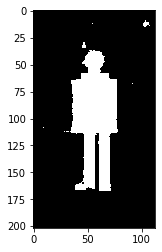

tensor([  9,  10,  11,  ..., 167, 167, 167])
tensor([ 4350,  4459,  4460,  ..., 18939, 18940, 18941])


In [16]:
centroids = get_centroids(embeddings, person_foreground, person_background)
# print("centroids:", centroids)
labels_shape = img.shape[-2], img.shape[-1]
heat_map = embeddings_accuracy(embeddings, person_flatten_labels, labels_shape, centroids, num_classes=2)
# t = .view(-1)
t = torch.tensor(heat_map)
foreground2 = torch.where(t == 1)[0]
plt.imshow(heat_map, cmap=plt.cm.gray)
plt.show()
print(foreground2)
print(person_foreground)

In [17]:
torch.save(model.state_dict(), 'Models/'+model_path+'.pt')

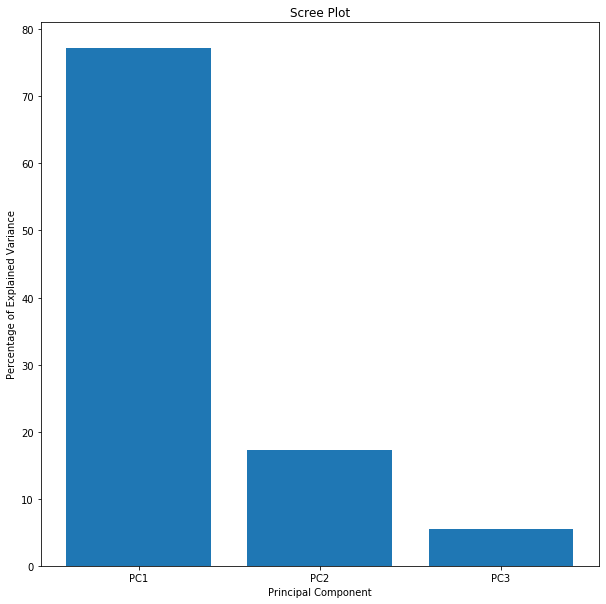

embedding1   -0.613252
embedding2   -0.594123
embedding3   -0.520519
dtype: float64


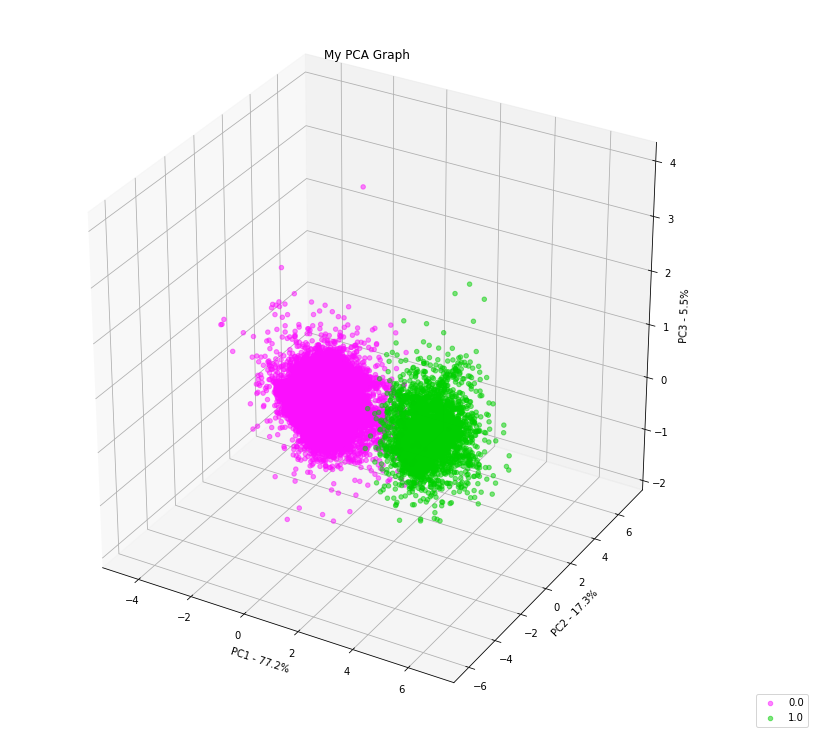

In [18]:
plot_PCA(embeddings, person_flatten_labels, out_features_size=out_features_size,classes= [0., 1.], colors=['#fc0fff', '#00cf00'], is_3D=True, draw_PCA_per_varc=True, figure_size=(10,10), top_range_loadingfactors=(0, 3))

### save Centroids

In [19]:
model_path = 'person_ResED_Minibatch_1'
centroid_path = 'Centroids/' + model_path + '_centroids' + '.pkl'
video_path = 'Videos/'+model_path+'.avi'

In [20]:
last_out_channel = 3
model = ResED(in_channels=3,
            n_classes=last_out_channel,
            depth=3,
            wf=6,
            padding=1,
            batch_norm=True,
            up_mode='upconv')

In [21]:
model.load_state_dict(torch.load('Models/'+model_path+'.pt'))

<All keys matched successfully>

In [22]:
out_features_size = last_out_channel
model.eval()

with torch.set_grad_enabled(False):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    img = person_img.to(device)
    model = model.to(device)
    embeddings = model(img)
embeddings = embeddings.data.cpu().numpy()
print("embeddings.shape:", embeddings.shape) # Datafram will contain 9025 rows and 8 col 
print("flatten_labels.shape:", person_flatten_labels.shape)
c, w = 0, 0
for i in embeddings:
    if np.array_equal(i, np.array([0.]*out_features_size)):
        c += 1
    else:
        w += 1
#     print(i)    
print("zeros count:", c)
print("not zeros count:", w)

embeddings.shape: (22826, 3)
flatten_labels.shape: torch.Size([22826])
zeros count: 0
not zeros count: 22826


correct: 22634, wrong: 192, accuracy: 99.15885393849119%


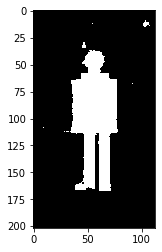

In [23]:
centroids = get_centroids(embeddings, person_foreground, person_background)
heat_map = embeddings_accuracy(embeddings, person_flatten_labels, labels_shape, centroids, num_classes=2)
plt.imshow(heat_map, cmap=plt.cm.gray)
plt.show()

In [24]:
save_centroids(centroid_path, centroids)
centroids_af = load_centroids(centroid_path)
assert np.array_equal(centroids_af, centroids)

### Create Video

In [25]:
model_path = 'person_ResED_Minibatch_1'
centroid_path = 'Centroids/' + model_path + '_centroids' + '.pkl'
video_path = 'Videos/'+model_path+'.avi'

In [26]:
last_out_channel = 3
model = ResED(in_channels=3,
            n_classes=last_out_channel,
            depth=3,
            wf=6,
            padding=1,
            batch_norm=True,
            up_mode='upconv')

In [27]:
centroids = load_centroids(centroid_path)
model.load_state_dict(torch.load('Models/'+model_path+'.pt'))

<All keys matched successfully>

In [28]:
frames_step = 3
real_heat_maps = easy_create_real_video(model, centroids, person_frames_cropped, video_path, person_width_cropped,
                                        person_height_cropped, froucc=cv2.VideoWriter_fourcc('M','J','P','G'),
                                        use_gpu=True, fps=10, frames_step=frames_step, num_classes=2,
                                        ret_heat_maps=True, heatmap_path = 'heatmaps/heatmap', img_ext = '.jpg')

Generate Heat Maps: 100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


Time Elapsed (get_heatmaps func) 1m 15s


<Figure size 432x288 with 0 Axes>

0.0005233862350414632
609.0327518680062


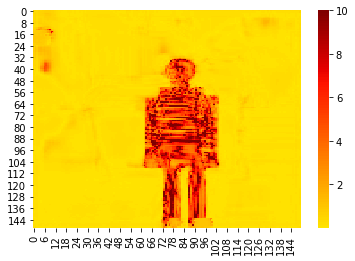

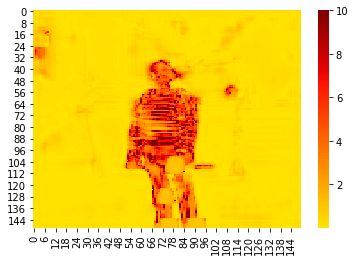

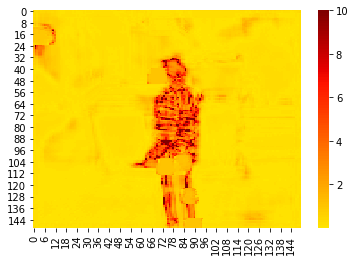

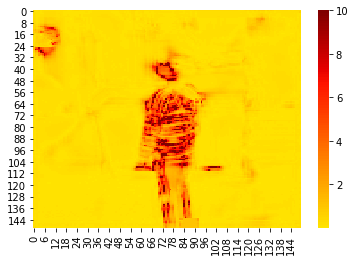

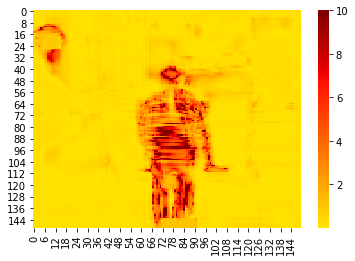

In [54]:
vmin, vmax = -20, 10

heat_map = sns.heatmap(real_heat_maps[0], cmap = 'jet', center=(vmin + vmax) / 2., vmax=vmax)
plt.show()
heat_map = sns.heatmap(real_heat_maps[25], cmap = 'jet', center=(vmin + vmax) / 2., vmax=vmax) 
plt.show()
heat_map = sns.heatmap(real_heat_maps[50], cmap = 'jet', center=(vmin + vmax) / 2., vmax=vmax) 
plt.show()
heat_map = sns.heatmap(real_heat_maps[75], cmap = 'jet', center=(vmin + vmax) / 2., vmax=vmax) 
plt.show()
heat_map = sns.heatmap(real_heat_maps[-1], cmap = 'jet', center=(vmin + vmax) / 2., vmax=vmax)
plt.show()